In [1]:
import pickle
import calendar
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import datetime
from regressors import stats as s
from dateutil import parser
from itertools import compress

from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils import shuffle

from xgboost import XGBRegressor, DMatrix

import warnings

warnings.filterwarnings("ignore")

sns.set(rc={"figure.figsize": (11.7, 8.27)})

In [113]:
dat = pd.read_csv("../Data/cleaned_data.csv")
dat = dat.loc[:, "Access":]

dat["Date Aired"] = pd.to_datetime(dat["Date Aired"], format="%Y-%m-%d")
dat["Time Aired"] = pd.to_datetime(dat["Time Aired"], format="%H:%M:%S").dt.time

hours = [x.hour for x in dat['Time Aired'].values]
dat["Hours"] = hours

In [114]:
outliers = pd.read_pickle('outlier_stations.pickle')
outlier_df = pd.DataFrame(outliers).reset_index()
outlier_df['bins'] = pd.qcut(outlier_df['Station ID'], q=7, labels = [1, 2, 3, 4, 5, 6, 7])
outlier_df.drop(0, axis=1, inplace=True)

outlier_stations = list(outliers.index.get_level_values('Station ID'))[0:12]
dat['is_outlier'] = np.where(np.isin(dat['Station ID'], outlier_stations), 1, 0)
dat = dat.join(outlier_df, on='Station ID', how='left', rsuffix='_')
dat['bins'] = dat['bins'].replace(np.nan, 0)
dat.drop('Station ID_', axis=1, inplace=True)

dat = pd.concat([dat, pd.get_dummies(dat['bins'])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["Estimate"])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["Access"])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["Market"])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["DOW"])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["daypart"])], axis=1)

dat.columns

Index([                        'Access',                            'DMA',
                           'Date Aired',                       'Estimate',
                                  'GRP',                     'Impression',
                     'Impression (000)',                    'Impressions',
                               'Length',                         'Market',
                                'Media',                      'Spot Cost',
                            'Spot Type',                     'Station ID',
                           'Time Aired',                            'DOW',
                              'daypart',                          'Hours',
                           'is_outlier',                           'bins',
                                    0.0,                              1.0,
                                    2.0,                              3.0,
                                    4.0,                              5.0,
                         

In [115]:
dat = dat.rename(columns={0.0: 'bin_0', 1.0: 'bin_1', 2.0: 'bin_2', 3.0: 'bin_3', 4.0: 'bin_4', 5.0: 'bin_5',
                  6.0: 'bin_6', 7.0: 'bin_7'})
dat = dat.rename(columns=lambda x: x.strip().replace(' ', '_'))
dat = pd.concat([dat, pd.get_dummies(dat['Hours'])], axis=1)
dat.columns

Index([              'Access',                  'DMA',           'Date_Aired',
                   'Estimate',                  'GRP',           'Impression',
           'Impression_(000)',          'Impressions',               'Length',
                     'Market',                'Media',            'Spot_Cost',
                  'Spot_Type',           'Station_ID',           'Time_Aired',
                        'DOW',              'daypart',                'Hours',
                 'is_outlier',                 'bins',                'bin_0',
                      'bin_1',                'bin_2',                'bin_3',
                      'bin_4',                'bin_5',                'bin_6',
                      'bin_7',                 'Q119',                 'Q219',
                       'Q319',                 'Q419',                 '15DC',
                       '15GD',                 '15PN',                 '30BP',
                       '30DE',                 '30DP

In [116]:
unseen = dat[(dat.Impressions.eq(0.0)) & (dat.GRP.eq(0.0))]
training = dat[dat.Impressions > 0.0]

labels = [
        "Length",
        "Spot_Cost",
        "Q119",
        "Q219",
        "Q319",
        "Q419",
        "15GD",
        "15PN",
        "30BP",
        "30DE",
        "30DP",
        "30GD",
        "30GX",
        "30PL",
        "30PM",
        "30PT",
        "30SR",
        "30TN",
        "30VE",
        "SV15",
        "Cable", 
        "DirecTV",
        "Dish_Network",
        "National_Network",
        "Over-the-top_content",
        "Monday",
        "Sunday",
        "Thursday",
        "Tuesday",
        "Wednesday",
        'bin_0',
        'bin_1',                
        'bin_2',                
        'bin_3',
        'bin_4',                
        'bin_5',                
        'bin_6',
        'bin_7',
              0, 1, 2, 3, 4, 5,                      6,                      7,
                            8,                      9,                     10,
                           11,                     12,                     13,
                           14,                     15,                     16,
                           17,                     18,                     19,
                           20,                     21,                     22,
                           23
    ]

X = training.loc[:,labels]
y = training.loc[:, "Impressions"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

## Ridge CV Tuning

In [117]:
rcv = RidgeCV(alphas=[1e-3, 1e-4, 1e-1, 1, 10], normalize=True)
rcv.fit(X_train, y_train)
rcv.score(X_train, y_train)

0.45449232741687023

In [118]:
rcv.get_params()

{'alphas': array([1.e-03, 1.e-04, 1.e-01, 1.e+00, 1.e+01]),
 'cv': None,
 'fit_intercept': True,
 'gcv_mode': None,
 'normalize': True,
 'scoring': None,
 'store_cv_values': False}

In [119]:
preds_rcv = rcv.predict(X_test)

## Ridge regression with SelectFromModel

In [120]:
mse_list = []
score_list = []
a_list = []
for a in [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]:
    ridge = Ridge(alpha=a, normalize=True, solver='sag', random_state=1234)
    
    ridge.fit(X_train, y_train)
    preds = ridge.predict(X_test)
    score_list.append(ridge.score(X_test, y_test))
    mse_list.append(MSE(y_test, preds))
    a_list.append(a)

In [121]:
ridge_results = pd.DataFrame(list(zip(a_list, score_list, mse_list)), 
                             columns = ['Alpha', 'R2', 'MSE'])

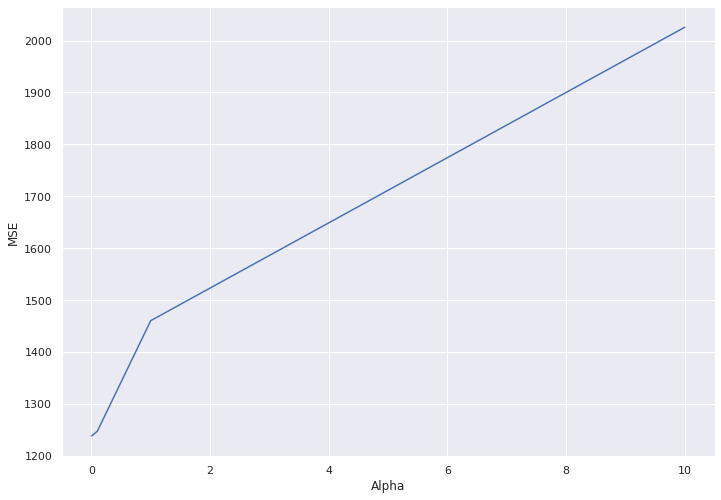

In [122]:
line = sns.lineplot('Alpha', 'MSE', data=ridge_results)
plt.show()

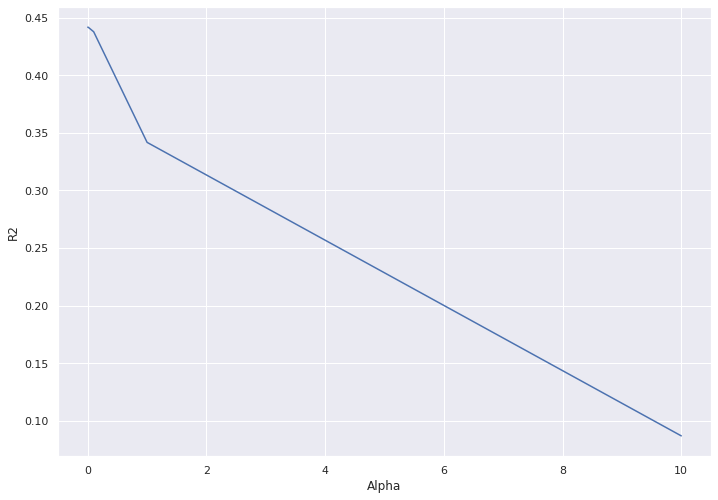

In [123]:
line = sns.lineplot('Alpha', 'R2', data=ridge_results)
plt.show()

In [124]:
rcv_list = [rcv.alpha_, rcv.score(X_test, y_test), MSE(y_test, rcv.predict(X_test)), np.sqrt(MSE(y_test, rcv.predict(X_test)))]
rcv_results = pd.DataFrame(rcv_list).transpose()
rcv_results

,0,1,2,3
0,0.001,0.441735,1238.516013,35.192556


In [125]:
ridge_results[ridge_results.MSE == ridge_results.MSE.min()]

,Alpha,R2,MSE
0,1.000000e-10,0.441747,1238.490546


In [126]:
selector_ridge = SelectFromModel(estimator=Ridge(alpha=1.000000e-10, normalize=True)).fit(X_train, y_train)
selector_ridge.get_support()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True,  True,  True, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False])

In [127]:
selected_labels = list(compress(labels, list(selector_ridge.get_support())))
selected_labels

X_adj = training.loc[:,selected_labels]
X_train_adj, X_test_adj, y_train_adj, y_test_adj = train_test_split(X_adj, y, test_size=0.25)

#### Ridge Regression with selected predictors

In [128]:
ridge_adjusted = Ridge(alpha=1.000000e-10, normalize=True)
ridge_adjusted.fit(X_train_adj, y_train_adj)
preds = ridge_adjusted.predict(X_test_adj)

print(ridge_adjusted.score(X_test_adj, y_test_adj))
print(MSE(y_test_adj, preds))

0.2384223646261615
1627.1572052623849


In [130]:
print(np.sqrt(MSE(y_test_adj, preds)))

40.33803670560064
